# About
Implement clustering algorithms
1. K-Means
1. Heirarchical clustering
1. DBSCAN

## The Team
| Name| Student ID|
|------------|---------------|
|Cynthia Cai | 5625483 |
|Pratyush Kumar | 5359252|


# Imports

// add the imports to the cell below

In [1]:
import numpy as np 
import pandas as pd
import random
import math
import scipy.spatial
from scipy.spatial import ConvexHull, distance_matrix
import glob
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

# Reading the dataset


From the readme for the xyz files, we know that:

Ground truth labels:
|File range|Label|
|--|--|
|    000 - 099: |building|
|    100 - 199: |car|
|    200 - 299: |fence|
|    300 - 399: |pole|
|    400 - 499: |tree|


workflow:

iterate through the files, and collect them in a dataframe

Use [this link](https://pandas.pydata.org/docs/reference/api/pandas.concat.html#pandas.concat) for concatenating the dataframes

In [2]:
xyzPath = './scene_objects/data/*.xyz'

dataPathsList = glob.glob(xyzPath)

In [3]:
allPointsDF= pd.DataFrame(columns=['x','y','z', 'fileNo', 'groundLabel'])
# featureDF = pd.DataFrame(columns=['Label' , 'convHull', median] )

labelToGive = None
for path in dataPathsList:
    indx = int(path.split('\\')[-1][0:3])
    # if else to determine label
    if indx>=0 and indx<100:
        labelToGive = 'building' 
    elif indx>=100 and indx<200:
        labelToGive = 'car' 
    elif indx>=200 and indx<300:
        labelToGive = 'fence' 
    elif indx>=300 and indx<400:
        labelToGive = 'pole' 
    elif indx>=400 and indx<500:
        labelToGive = 'tree' 

    # print(indx, labelToGive)        

    # using pandas to read dataset and make a dataFrame
    tempDF = pd.read_csv(path, delimiter=' ', header=None, dtype=np.float64, names=['x','y','z'])
    tempDF.loc[:,'fileNo'] = indx
    tempDF.loc[:,'groundLabel'] = labelToGive

    # merge with megaDFofPoints
    allPointsDF = pd.concat([allPointsDF, tempDF], sort=False, ignore_index=True)

allPointsDF.head()

,x,y,z,fileNo,groundLabel
0,20.070000,499.959991,17.450001,0,building
1,20.370001,499.160004,17.290001,0,building
2,18.860001,499.559998,18.129999,0,building
3,18.120001,499.709991,18.540001,0,building
4,17.360001,499.950012,19.000000,0,building


In [ ]:
# save to pickle file
# allPointsDF.to_pickle('./scene_objects/compressedData.pkl')

## Making feature points
Identified feature points: `//add more`
* median height(z)
* convex hull

In [21]:
def label_determiner(idx):
    labelToGive=None
    if idx>=0 and idx<100:
        labelToGive = 'building' 
    elif idx>=100 and idx<200:
        labelToGive = 'car' 
    elif idx>=200 and idx<300:
        labelToGive = 'fence' 
    elif idx>=300 and idx<400:
        labelToGive = 'pole' 
    elif idx>=400 and idx<500:
        labelToGive = 'tree' 
    return labelToGive


featureDF = allPointsDF.groupby('fileNo').var()
featureDF.rename(columns={'x':'varX','y':'varY','z':'varZ'}, inplace=True)
featureDF.loc[:,'median_Z'] = allPointsDF.groupby('fileNo').z.median()
# featureDF.loc[:,'mean_Z'] = allPointsDF.groupby('fileNo').z.mean()

# range of x,y,z
# featureDF.loc[:,'range_X'] = allPointsDF.groupby('fileNo').x.max() - allPointsDF.groupby('fileNo').x.min()
# featureDF.loc[:,'range_Y'] = allPointsDF.groupby('fileNo').y.max() - allPointsDF.groupby('fileNo').y.min()
featureDF.loc[:,'range_Z'] = allPointsDF.groupby('fileNo').z.max() - allPointsDF.groupby('fileNo').z.min()

featureDF.loc[:,'Volume'] = allPointsDF.set_index('fileNo').loc[:,'x':'z'].groupby('fileNo').apply(ConvexHull).apply(lambda x: x.volume)

# points density
#featureDF.loc[:,'footprintDensity'] =  allPointsDF.groupby('fileNo').count().x / (featureDF.range_X * featureDF.range_Y)
featureDF.loc[:,'volumeDensity'] =  allPointsDF.groupby('fileNo').count().x / featureDF.Volume

# label
featureDF.loc[:,'label'] = featureDF.reset_index().fileNo.apply(label_determiner)

# delete 
del featureDF['varX']
del featureDF['varY']
del featureDF['varZ']

# standardize DF
standardFeatureDF = (featureDF.iloc[:,:-1] - featureDF.iloc[:,:-1].mean() ) / featureDF.iloc[:,:-1].std()

# join labels to the feature DF
standardFeatureDF = standardFeatureDF.join(other=featureDF.label ,on='fileNo')

featureDF.to_pickle('./scene_objects/featureData.pkl')
standardFeatureDF.to_pickle('./scene_objects/standardFeatureData.pkl')

standardFeatureDF

,median_Z,range_Z,Volume,volumeDensity,label
fileNo,,,,,
0,1.959990,-0.193223,-0.226519,-0.015205,building
1,-0.567404,-0.504040,-0.201540,-0.151984,building
2,0.848326,0.347423,0.634529,-0.634648,building
3,1.111039,0.255491,0.693879,-0.599754,building
4,-0.501725,-0.151635,0.523874,-0.401196,building
...,...,...,...,...,...
495,-0.662272,0.281758,-0.200372,0.127909,tree
496,-0.005490,1.430905,0.180814,-0.440335,tree
497,-0.603891,0.205148,-0.241283,-0.230490,tree


### Plotting to see resemblamces and clusters, if any
needed: seaborn

In [2]:
# load df's
featureDF = pd.read_pickle('./scene_objects/featureData.pkl')
standardFeatureDF = pd.read_pickle('./scene_objects/standardFeatureData.pkl')

In [ ]:
sns.pairplot(data=featureDF, hue="label")

normalize the feature df </br>
[from stackoverflow we see](https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame), that we can just use pandas for a standard scaling, or else, a [standard scaler from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) can also be applied </br>

from [answer here](https://stats.stackexchange.com/questions/417339/data-standardization-vs-normalization-for-clustering-analysis), we see that standard scaler is used for k means , so we are going with that

In [ ]:
sns.pairplot(data=standardFeatureDF, hue="label")

# Clustering Algorithms
note: already loaded the featureDF and standardised in the cell above

## K-Means clustering

In [22]:
def kmeans(featureDF, k):
    """
    Using DBScan method to cluster feature points.
    Input parameter:
        featureDF: a DataFrame that stores feature points with label
        k: the number of clusters
    Output:
        cluster: a list of dataframes
        C = [C0,C1,C2,C3,C4]
        Cx is a DataFrame with the same column of featureDF
    """
    #pre-step: setting parameters and format conversion
    MaxInteration, epsilon = 50, 0.0000000000000000000000000000000000000000000000000000000000001

    column_name = featureDF.columns.values.tolist()

    pts_label_array = featureDF.to_numpy() # has 500 elements
    pts_array = featureDF.loc[:,'median_Z':'volumeDensity'].to_numpy()

    cluster = [pd.DataFrame(columns = column_name)] * k # a list of dataframes(cluster)
    # Step1: initialize k centroids (array)
    centroid_idx = np.random.randint(0,len(pts_array),k).tolist()
    centroid_array = pts_array[centroid_idx]

    # step2: assign each point to a cluster
    interation = 0
    centroid_change = []
    while interation <= MaxInteration:
        interation += 1

        cls_0, cls_1, cls_2, cls_3, cls_4 = [], [], [], [], []

        tree = scipy.spatial.cKDTree(centroid_array)
        for j in range(0,len(pts_array)):
            pt = pts_array[j]
            d, i = tree.query(pt) # i is the index of centroid
            
            if i == 0:
                cls_0.append(j)
            elif i == 1:
                cls_1.append(j)
            elif i == 2:
                cls_2.append(j)
            elif i == 3:
                cls_3.append(j)
            elif i == 4:
                cls_4.append(j)
            
        cluster = []
        cluster.append(standardFeatureDF.iloc[cls_0])
        cluster.append(standardFeatureDF.iloc[cls_1])
        cluster.append(standardFeatureDF.iloc[cls_2])
        cluster.append(standardFeatureDF.iloc[cls_3])
        cluster.append(standardFeatureDF.iloc[cls_4])

        # step3: update centroids
        old_centroid_array = centroid_array
        #print(interation," centroid",old_centroid_array)
        for i in range(0,k):
            centroid_array[i] = cluster[i].mean(axis = 0).to_numpy() # the input is a list of arrays
            #print(centroid_array[i])
            dist = scipy.spatial.distance.euclidean(old_centroid_array[i], centroid_array[i])
            if dist <= epsilon:
                break
    
    return(cluster)

In [23]:
kmeans_cls = kmeans(standardFeatureDF, 5)
kmeans_cls

C:\Users\cynthia\AppData\Local\Temp/ipykernel_43384/1266985147.py:60: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  centroid_array[i] = cluster[i].mean(axis = 0).to_numpy() # the input is a list of arrays


[        median_Z   range_Z    Volume  volumeDensity     label
 fileNo                                                       
 6      -0.560106 -0.928677 -0.245457       1.418477  building
 25     -0.127116 -0.827990 -0.196947       0.387381  building
 32     -0.183065 -0.519362 -0.191003       0.401694  building
 65     -0.599026 -0.963699 -0.266881       1.602550  building
 79     -0.689030 -0.889278 -0.242471       1.445283  building
 ...          ...       ...       ...            ...       ...
 402    -0.555241 -0.355198 -0.297731       0.620093      tree
 428    -0.572269 -0.705414 -0.299487       1.020191      tree
 454    -0.564971 -0.440563 -0.292528       0.339463      tree
 457    -0.717004 -0.718547 -0.296518       0.339005      tree
 458     0.140461 -0.342065 -0.287178       0.414483      tree
 
 [133 rows x 5 columns],
         median_Z   range_Z    Volume  volumeDensity     label
 fileNo                                                       
 1      -0.567404 -0.504040 

## Heirarchical clustering

This [ref was nice](https://www.section.io/engineering-education/hierarchical-clustering-in-python/) for heirarchical clustering understanding
Some other sources:
* [Statquest](https://www.youtube.com/watch?v=7xHsRkOdVwo&ab_channel=StatQuestwithJoshStarmer)
* Penn state [pseudo code](https://online.stat.psu.edu/stat508/lesson/12/12.7)
* pseudo code from [researchgate](https://www.researchgate.net/figure/The-hierarchical-clustering-algorithm-in-pseudocode_fig1_202144697)
* towards data science article to do [step by step](https://towardsdatascience.com/breaking-down-the-agglomerative-clustering-process-1c367f74c7c2) {this is a good one to follow}
* another one [for theory](https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019)
* similar [theory as above](https://www.geeksforgeeks.org/ml-hierarchical-clustering-agglomerative-and-divisive-clustering/)
* real good [step by step explaination](https://medium.com/@darkprogrammerpb/agglomerative-hierarchial-clustering-from-scratch-ec50e14c3826), also the [github code](https://github.com/Darkprogrammerpb/DeepLearningProjects/blob/master/Project40/agglomerative_hierarchial_clustering/Hierarchial%20Agglomerative%20clustering.ipynb)

### To Think in heirarchical clustering:
* Which type of heirarchical clustering are we doing: lets begin with agglomerative clustering
* Within the selected type what distance metrics are we using



devise new distance matrix and then repeat the sequence:
### TODO: 
* linkage between the clusters
* updation of the distance matrix

clusters to be made:
`vals.idxmin()` and `idVals.iloc[vals.idxmin()]`

* inter cluster distance 
    * threshold
* distance types
    * calculate distance yourself
* convert to function
* check for number of clusters

In [24]:
def hierarchy(standardizedDF, linkageType='complete'):
    """
    Summary:
            This function takes in a standardized dataframe with features of objects and returns a list of clusters based on the indices of the dataframe, 
            note: the distances are calculated on basis of minkowski distance
    Arguments:
            standardizedDF (pd.DataFrame): standardized dataframe
            linkageType (str) : can be 'complete' for complete linkage, 'single' for single linkage and 'average' for average linkage
    Return (list) : a list of indices based on the dataframe input, with clusters inside the list, every list will have a length of 2
    """        
    tempDF = standardizedDF.iloc[:,:-1].copy()

    distMatDF = pd.DataFrame(distance_matrix(tempDF.values, tempDF.values), index = tempDF.index, columns = tempDF.index)
    # replace 0 distances with np.nan
    distMatDF = distMatDF.where(distMatDF!=0, np.nan)
        
    # clustCHECK WILL have two nodes each and a full node
    clustCheck = {}
    iterationCounter=0
    m=len(distMatDF)

    while m>1: 

        # cluster size
        # print(f"Total sample = {m}")
        # compute distances

        # get indices with min dist
        vals = distMatDF.min(skipna=True)
        idVals = distMatDF.idxmin(skipna=True)

        ind_to_pop = [idVals.loc[vals.idxmin()] , vals.idxmin()]
        # update distmatrix 
        ## add updated new row, col to dist mat  
        ## this updated row is basically the minimum of the two eliminated rows
        if linkageType=='complete':
            singleLink_minRow = distMatDF.loc[ind_to_pop].drop(ind_to_pop, axis=1).max()
        elif linkageType=='single':
            singleLink_minRow = distMatDF.loc[ind_to_pop].drop(ind_to_pop, axis=1).min()
        elif linkageType=='average':
            singleLink_minRow = distMatDF.loc[ind_to_pop].drop(ind_to_pop, axis=1).mean()

        singleLink_minRow.rename(f"cluster {iterationCounter}", inplace=True)

        # pop row and col from dist mat
        distMatDF = distMatDF.drop(ind_to_pop, axis=0).drop(ind_to_pop, axis=1)

        # min distance from other points
        distMatDF = distMatDF.append(singleLink_minRow)
        distMatDF.loc[:,singleLink_minRow.name] = singleLink_minRow
        # update value of m
        m = len(distMatDF)

        indPop1, indPop2 = ind_to_pop

        clustCheck[f"cluster {iterationCounter}"] = {'node1':indPop1 , "node2":indPop2, 'fullnodes':ind_to_pop}
        # print("before" , clustCheck[f'cluster {iterationCounter}'])
        
        # Case: if first index is a cluster
        if (indPop1 in clustCheck.keys()) and (indPop2 in clustCheck.keys()): #both are clusters
            clustCheck[f"cluster {iterationCounter}"] = {'node1':clustCheck[indPop1]['fullnodes'].copy() , "node2":clustCheck[indPop2]['fullnodes'].copy() }
            tempFull = [clustCheck[f"cluster {iterationCounter}"]["node1"].copy(), clustCheck[f"cluster {iterationCounter}"]["node2"].copy()]
            clustCheck[f"cluster {iterationCounter}"]["fullnodes"] = tempFull  


        # Case: if first index is a cluster
        elif indPop1 in clustCheck.keys(): #means first position is cluster
            clustCheck[f"cluster {iterationCounter}"] = {'node1':clustCheck[indPop1]['fullnodes'].copy() , "node2":indPop2 }
            tempFull = [clustCheck[f"cluster {iterationCounter}"]["node1"].copy() , clustCheck[f"cluster {iterationCounter}"]["node2"]]
            clustCheck[f"cluster {iterationCounter}"]["fullnodes"] = tempFull

        # Case: if second index is a cluster
        elif indPop2 in clustCheck.keys(): #means first position is cluster
            clustCheck[f"cluster {iterationCounter}"] = {'node1':indPop1 , "node2":clustCheck[indPop2]['fullnodes'].copy()}
            tempfull=[clustCheck[f"cluster {iterationCounter}"]["node1"].copy() , clustCheck[f"cluster {iterationCounter}"]["node2"]]
            clustCheck[f"cluster {iterationCounter}"]["fullnodes"] =  tempFull

        iterationCounter+=1
    return clustCheck

In [26]:
clsCheck = hierarchy(standardFeatureDF)
clsCheck

{'cluster 0': {'node1': 96, 'node2': 83, 'fullnodes': [96, 83]},
 'cluster 1': {'node1': 168, 'node2': 108, 'fullnodes': [168, 108]},
 'cluster 2': {'node1': 160, 'node2': 136, 'fullnodes': [160, 136]},
 'cluster 3': {'node1': 255, 'node2': 151, 'fullnodes': [255, 151]},
 'cluster 4': {'node1': 462, 'node2': 414, 'fullnodes': [462, 414]},
 'cluster 5': {'node1': 268, 'node2': 185, 'fullnodes': [268, 185]},
 'cluster 6': {'node1': 375, 'node2': 352, 'fullnodes': [375, 352]},
 'cluster 7': {'node1': 72, 'node2': 53, 'fullnodes': [72, 53]},
 'cluster 8': {'node1': 144, 'node2': 123, 'fullnodes': [144, 123]},
 'cluster 9': {'node1': 181, 'node2': 171, 'fullnodes': [181, 171]},
 'cluster 10': {'node1': 175, 'node2': 167, 'fullnodes': [175, 167]},
 'cluster 11': {'node1': [268, 185],
  'node2': 193,
  'fullnodes': [[268, 185], 193]},
 'cluster 12': {'node1': 69, 'node2': 31, 'fullnodes': [69, 31]},
 'cluster 13': {'node1': 273, 'node2': 267, 'fullnodes': [273, 267]},
 'cluster 14': {'node1':

In [27]:
clsCheck = hierarchy(standardFeatureDF)
clsList = clsCheck[list(clsCheck.keys())[-1]]["fullnodes"]

def flatten(l):
    try:
        return flatten(l[0]) + (flatten(l[1:]) if len(l) > 1 else []) if type(l) is list else [l]
    except IndexError:
        return []

# clusters are hardcoded in the following variables
cls1Indices = flatten(clsList[0][0][0][0])
clsIndices = flatten(clsList[0][0][0][1])
cls3Indices = flatten(clsList[0][0][1])
cls4Indices = flatten(clsList[0][1])
cls5Indices = flatten(clsList[1])

hierarchy_cls = [standardFeatureDF.loc[i] for i in [cluster1Indices,cluster2Indices,cluster3Indices,cluster4Indices,cluster5Indices] ]
hierarchy_cls

[        median_Z   range_Z    Volume  volumeDensity     label
 fileNo                                                       
 226    -0.890930 -0.731680  0.580761      -0.990374     fence
 224    -0.759573 -0.563139  0.730994      -1.006320     fence
 261    -1.036881 -0.720736  0.647553      -0.987651     fence
 286    -1.063639 -0.377086  1.332857      -1.020340     fence
 245    -0.635514 -0.681337  0.198110      -0.963058     fence
 ...          ...       ...       ...            ...       ...
 57      1.536731  0.119783  0.490302      -0.531609  building
 11      1.344561  0.163560  0.514914      -0.523956  building
 387     3.520455  3.234518 -0.218391      -0.958692      pole
 377     3.295447  3.140398 -0.263982      -0.866373      pole
 444     3.638433  3.794864  0.808460      -0.736611      tree
 
 [488 rows x 5 columns],
         median_Z   range_Z    Volume  volumeDensity     label
 fileNo                                                       
 252    -1.151210 -0.606916 

In [28]:
hierarchy_cls[0]

,median_Z,range_Z,Volume,volumeDensity,label
fileNo,,,,,
226,-0.890930,-0.731680,0.580761,-0.990374,fence
224,-0.759573,-0.563139,0.730994,-1.006320,fence
261,-1.036881,-0.720736,0.647553,-0.987651,fence
286,-1.063639,-0.377086,1.332857,-1.020340,fence
245,-0.635514,-0.681337,0.198110,-0.963058,fence
...,...,...,...,...,...
57,1.536731,0.119783,0.490302,-0.531609,building
11,1.344561,0.163560,0.514914,-0.523956,building
387,3.520455,3.234518,-0.218391,-0.958692,pole


In [29]:
hierarchy_cls[1]

,median_Z,range_Z,Volume,volumeDensity,label
fileNo,,,,,
252,-1.151210,-0.606916,1.452026,-1.021547,fence
204,-0.934715,-0.698848,1.290510,-1.009591,fence
215,-0.574701,-0.567517,1.122542,-1.024739,fence
288,-0.800926,-0.458074,1.187799,-0.999585,fence
213,-0.589296,-0.504040,3.242568,-1.035882,fence
289,-0.669570,-0.666015,2.575224,-1.019071,fence
248,-1.462573,-0.530306,1.916946,-1.034548,fence
64,0.191544,0.769871,4.312063,-0.792212,building
15,0.167219,0.802704,4.027059,-0.792343,building


In [30]:
hierarchy_cls[2]

,median_Z,range_Z,Volume,volumeDensity,label
fileNo,,,,,
163,-0.869037,-1.184773,-0.30436,7.034694,car


In [31]:
hierarchy_cls[3]

,median_Z,range_Z,Volume,volumeDensity,label
fileNo,,,,,
247,-0.934715,-0.563139,4.346387,-1.025261,fence


In [32]:
hierarchy_cls[4]

,median_Z,range_Z,Volume,volumeDensity,label
fileNo,,,,,
60,0.111271,0.776438,18.569752,-0.766191,building


## DBSCAN

In [33]:
def dbscan(featureDF, radius, MinPts):
    """
    Using DBScan method to cluster feature points.
    Input parameter:
        featureDF: a DataFrame that stores feature points with label
        radius: the radius of search circle 
        MinPts: the minimum number of neighbor points required for a core point
    Output:
        cluster: a list of dataframes
        C = [C0,C1,C2,C3,C4]
        Cx is a DataFrame with the same column of featureDF
    """
    # pre-step: data structure and kdtree
    column_name = featureDF.columns.values.tolist()

    pts_label_list = featureDF.to_numpy().tolist()
    pts_array = featureDF.loc[:,'median_Z':'volumeDensity'].to_numpy() # an array of arrays (all pts)
    tree = scipy.spatial.cKDTree(pts_array)

    # step1: generate core points
    wait_idx = [*range(0,len(pts_array))] # a list index (wait pts)
    core_idx = [] # a list of index (core pts)
    for i in wait_idx:
        pt = pts_array[i]
        neighbor = tree.query_ball_point(pt, radius) # a list of indexs of neighbors
        if len(neighbor) >= MinPts:
            core_idx.append(i) 

    # step2: pick a random core point and start the loop (using queue)
    # initialize cluster number and waiting list
    k = 0
    cluster = []

    while len(core_idx) > 0:
        clusterDF = pd.DataFrame(columns=column_name)
        
        start_idx = random.sample(core_idx,1)[0]
        queue = [start_idx]
        core_idx.remove(start_idx)
        wait_idx.remove(start_idx)
        clusterDF.append(pts_label_list[start_idx])

        # step3: process each pt in queue
        # first of all: core or non-core?
        # for a non-core point, assign it to a cluster (done)
        # for a core neighbor point, assign it to a cluster (done) and add its neighbors to queue
        while len(queue) > 0:
            pt = pts_array[queue.pop(0)] 
            neighbor_idx = tree.query_ball_point(pt, radius) # a list of indexs (neighbor pts)       
            
            if len(neighbor_idx) >= MinPts:
                for index in neighbor_idx:
                    if index in wait_idx: # points: (1) unprocessed; (2) in the neighborhood
                        queue.append(index)
                        wait_idx.remove(index)
                        clusterDF.loc[len(clusterDF.index)] = pts_label_list[index]
                        if index in core_idx:
                            core_idx.remove(index)
        
        # step4: store the new cluster
        k = k + 1
        cluster.append(clusterDF)

        if k > 10:
            break
            print("DBScan clusters out of ten!")

    return(cluster)


In [34]:
dbscan_cls = dbscan(standardFeatureDF,0.6,5)
dbscan_cls

[     median_Z   range_Z    Volume  volumeDensity  label
 0    0.310738  1.352106 -0.081842      -0.634646   tree
 1    0.398309  1.380561 -0.125777      -0.642913   tree
 2    0.425067  1.638845 -0.076830      -0.622559   tree
 3    0.510205  1.520648  0.118678      -0.499018   tree
 4    0.428716  1.785499 -0.028857      -0.667615   tree
 ..        ...       ...       ...            ...    ...
 472 -1.090397 -1.053442 -0.300956       2.771158    car
 473 -0.866604 -1.053442 -0.301821       2.940525    car
 474 -1.212023 -0.979021 -0.302218       2.969839    car
 475 -1.645012 -0.692281  1.251336      -1.018638  fence
 476 -1.462573 -0.530306  1.916946      -1.034548  fence
 
 [477 rows x 5 columns]]

# Validation
* take numbner of output classification in a cluster and check with the actual calues

In [38]:
def pair(m):
    pair_idx = []
    for i in range(0, m):
        for j in range(0,m):
            if i<j:
                pair_idx.append([i,j])

    return pair_idx

def external_index(ss, sd, ds, dd):
    # step4: compute external indicator
    jc = ss / (ss+sd+ds) # Jaccard Coefficient
    fmi = ss / math.sqrt((ss+sd)*(ss+ds)) # Fowlkes and Mallows
    ri = (ss+dd) / (ss+sd+ds+dd) # Rand Index

    return [jc, fmi, ri]

def validation(cluster):
    # step1: merge all clusters to a validDF
    labelDF = pd.DataFrame(columns = ['actual_label','predict_label'])

    for cls in cluster:
        addDF = pd.DataFrame(cls.loc[:,'label'])
        addDF.rename(columns={'label':'actual_label'}, inplace = True)
        addDF['predict_label'] = [cls['label'].value_counts().idxmax()] * len(cls)

        labelDF = pd.concat([labelDF, addDF], sort=False, ignore_index=True)

    # step2: pair up
    pair_idx = pair(len(labelDF))

    # step3: go through all possibilities for each pair
    ss, sd, ds, dd = 0, 0, 0, 0
    for [i,j] in pair_idx:
        i_act, i_pre = labelDF['actual_label'][i], labelDF['predict_label'][i]
        j_act, j_pre = labelDF['actual_label'][j], labelDF['predict_label'][j]
        if i_act == i_pre and j_act == j_pre:
            ss += 1
        elif i_act == i_pre and j_act != j_pre:
            sd += 1
        elif i_act != i_pre and j_act == j_pre:
            ds += 1
        elif i_act != i_pre and j_act != j_pre:
            dd += 1

    # step4: compute external indicator
    return external_index(ss, sd, ds, dd)

validation for our implementation

In [40]:
kmeans_validation = validation(kmeans_cls)
hierarchy_validation = validation(hierarchy_cls)
dbscan_validation = validation(dbscan_cls)

validDF = pd.DataFrame([kmeans_validation, hierarchy_validation, dbscan_validation], index=['kmeans', 'hierarchy', 'dbscan'], columns = ["Jaccard Coefficient", "Fowlkes and Mallows", "Rand Index"])
validDF

,Jaccard Coefficient,Fowlkes and Mallows,Rand Index
kmeans,0.452693,0.623251,0.529812
hierarchy,0.122610,0.261642,0.656112
dbscan,0.113450,0.288198,0.672833


validation for scipy implementation

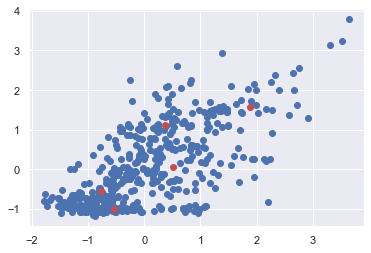

In [41]:
'''
reference
vq: https://docs.scipy.org/doc/scipy/reference/cluster.vq.html#module-scipy.cluster.vq
hierarchical: https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html
dbscan:
'''

import scipy.cluster

pts_array = standardFeatureDF.loc[:,'median_Z':'volumeDensity'].to_numpy()
kmeans_whitened = scipy.cluster.vq.whiten(pts_array)
kmeans_codebook, kmeans_distortion = scipy.cluster.vq.kmeans(pts_array,5)

# Plot whitened data and cluster centers in red
plt.scatter(kmeans_whitened[:, 0], kmeans_whitened[:, 1])
plt.scatter(kmeans_codebook[:, 0], kmeans_codebook[:, 1], c='r')
plt.show()